## Testing relation extraction

In [1]:
from dataset_creator import *

configs_train = {
    "num_files":30,
    "images_dir" : "images",
    "images_resized_dir" : "images_resized",
    "bbox_dir":"bbox",
    "input_ids_dir" : "input_ids",
    "labels_dir" : "labels",
    "entities_dir" : "entities",
    "relations_dir" : "relations",
    "type":"train",
    "clear_all_old_files" : True,
    "clear_old_files_type": [True, "validation"]
}

configs_validation = {
    "num_files":30,
    "images_dir" : "images",
    "images_resized_dir" : "images_resized",
    "bbox_dir":"bbox",
    "input_ids_dir" : "input_ids",
    "labels_dir" : "labels",
    "entities_dir" : "entities",
    "relations_dir" : "relations",
    "type":"validation",
    "clear_all_old_files" : True,
    "clear_old_files_type": [True, "validation"]
}

configs_train = {key:val for key,val in configs_train.items() if key not in ("num_files", "clear_all_old_files", "clear_old_files_type")}
configs_validation = {key:val for key,val in configs_validation.items() if key not in ("num_files", "clear_all_old_files", "clear_old_files_type")}

dataset_train = Custom_Dataset(**configs_train)
dataset_validation = Custom_Dataset(**configs_validation)

/home/a8hik/anaconda3/envs/py3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Modified Collator for key value extraction (removing labels) 

In [38]:
@dataclass
class DataCollatorForTokenClassificationModified:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.

    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    feature_extractor: LayoutLMv2FeatureExtractor
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def __call__(self, features):
        # prepare image input
        image = self.feature_extractor([feature["original_image"] for feature in features], return_tensors="pt").pixel_values

        # prepare text input
        for feature in features:
            del feature["image"]
            del feature["id"]
            del feature["original_image"]
            del feature["entities"]
            del feature["relations"]
            del feature["labels"] ## This is added for debugging relation extraction. But this line must be removed if training for token classification

        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt"
        )

        batch["image"] = image

        return batch

data_collator_tc = DataCollatorForTokenClassification(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=512,
)

@dataclass
class DataCollatorForTokenClassificationVisualDebug:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.

    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    feature_extractor: LayoutLMv2FeatureExtractor
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def __call__(self, features):
        # prepare image input
        image = self.feature_extractor([feature["original_image"] for feature in features], return_tensors="pt").pixel_values

        # prepare text input
        for feature in features:
            del feature["image"]
            del feature["id"]
            #del feature["original_image"]
            del feature["entities"]
            del feature["relations"]
            del feature["labels"] ## This is added for debugging relation extraction. But this line must be removed if training for token classification

        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt"
        )

        batch["image"] = image

        return batch

data_collator_tc = DataCollatorForTokenClassification(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=512,
)

In [39]:
from transformers import LayoutLMv2FeatureExtractor
tokenizer = AutoTokenizer.from_pretrained("trained_models/July_01/tokenizer_added_tokens/")

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=True)
data_collator_tc = DataCollatorForTokenClassificationModified(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=512,
)
data_collator = DataCollatorForKeyValueExtraction(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=8,
    padding="max_length",
    max_length=512,
)

data_collator_visual = DataCollatorForTokenClassificationVisualDebug(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=8,
    padding="max_length",
    max_length=512,
)


train_dataset = dataset_train
test_dataset = dataset_validation

In [56]:

from transformers import AutoModelForTokenClassification
#os.path.exists("trained_models/July_01/token_classification_custom")
model = AutoModelForTokenClassification.from_pretrained("trained_models/July_01/token_classification_custom")
test_dataset_custom_tc = dataset_validation
dataloader_tc = DataLoader(test_dataset, batch_size=1, collate_fn=data_collator_tc)

dataloader_tc_visual = DataLoader(test_dataset, batch_size=1, collate_fn=data_collator_visual)
dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=data_collator)
tc_iter = iter(dataloader_tc)
visual_iter = iter(dataloader_tc_visual)
test_iter = iter(dataloader)


[ WARN:0@2311.858] global loadsave.cpp:244 findDecoder imread_('dataset/validation/images_resized/image_resized_0.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@2314.554] global loadsave.cpp:244 findDecoder imread_('dataset/validation/images_resized/image_resized_0.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@2339.348] global loadsave.cpp:244 findDecoder imread_('dataset/validation/images_resized/image_resized_0.jpeg'): can't open/read file: check file path/integrity


[ WARN:0@11313.987] global loadsave.cpp:244 findDecoder imread_('dataset/validation/images_resized/image_resized_3.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@11316.526] global loadsave.cpp:244 findDecoder imread_('dataset/validation/images_resized/image_resized_3.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@11340.148] global loadsave.cpp:244 findDecoder imread_('dataset/validation/images_resized/image_resized_3.jpeg'): can't open/read file: check file path/integrity


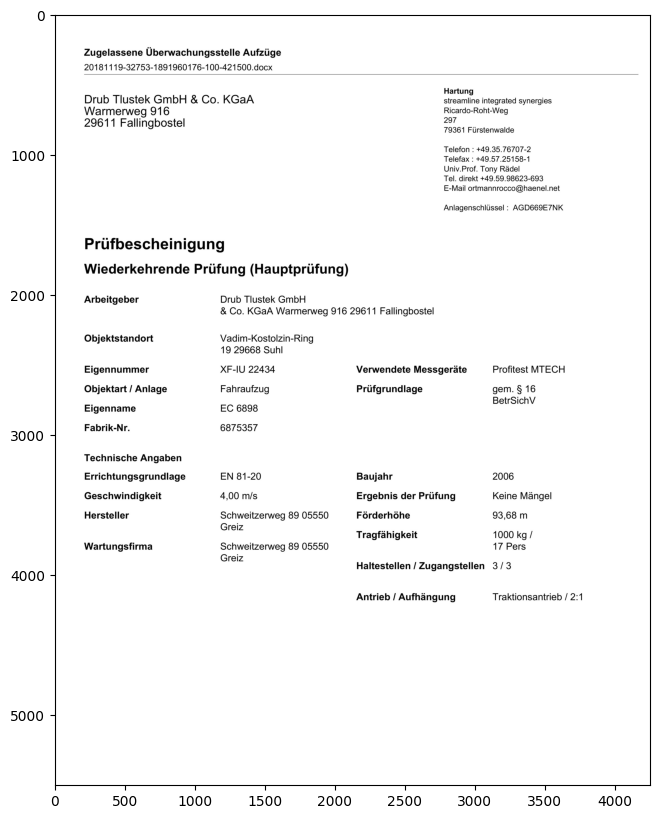

In [65]:
test_batch_tc = next(tc_iter)
test_batch_visual = next(visual_iter)
test_batch = next(test_iter)

device = "cuda" if torch.cuda.is_available() else "cpu"
test_image_1 = Image.fromarray(test_batch_visual['original_image'].cpu().detach().numpy()[0])

plt.figure(figsize=(15,10))
plt.imshow(test_image_1)


In [66]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

#inputs = inputs.to(device)

inputs = test_batch_tc
model.to(device)
inputs = inputs.to(device)

#offset_mapping = inputs.pop("offset_mapping")

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

In [67]:
import numpy as np

# take argmax on last dimension to get predicted class ID per token
predictions = outputs.logits.argmax(-1).squeeze().tolist()
print(predictions)
# we're only interested in tokens which aren't subwords
# we'll use the offset mapping for that
#is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

id2label = {"HEADER":0, "QUESTION":1, "ANSWER":2}

# finally, store recognized "question" and "answer" entities in a list
entities = []
current_entity = None
start = None
end = None
entity_local = []
#for idx, (id, pred) in enumerate(zip(inputs.input_ids[0].tolist(), predictions)):
for idx, (id, pred) in enumerate(zip(test_batch_tc['input_ids'][0].tolist(), predictions)):
  #if not is_subword[idx]:
  predicted_label = model.config.id2label[pred]
  if predicted_label.startswith("B"):
    if len(entity_local)==0:
      entity_local.append(idx)
      current_entity = predicted_label.replace("B-", "")
    else:
      entity_local.append(idx)
      start = entity_local[0]
      end = entity_local[-1]
      entities.append((start, end, current_entity, id2label[current_entity]))
      entity_local = []
      entity_local.append(idx)
      #current_entity = None

  if predicted_label.startswith("I"):
    current_entity = predicted_label.replace("I-", "")
    entity_local.append(idx)
  print(tokenizer.decode([id]), predicted_label)

[0, 0, 0, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 1, 1, 1, 1, 5, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2, 4, 4, 4, 2, 4, 4, 4, 1, 5, 1, 1, 1, 5, 4, 1, 1, 1, 5, 1, 5, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 4, 4, 0, 4, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [68]:
from transformers import LayoutLMv2ForRelationExtraction

# step 2: run LayoutLMv2ForRelationExtraction /content/drive/MyDrive/relation_extraction
#relation_extraction_model = LayoutLMv2ForRelationExtraction.from_pretrained("nielsr/layoutxlm-finetuned-xfund-fr-re")
relation_extraction_model = LayoutLMv2ForRelationExtraction.from_pretrained("trained_models/July_01/relation_extraction_custom")
relation_extraction_model.to(device)

entity_dict = {'start': [entity[0] for entity in entities],
        'end': [entity[1] for entity in entities],
        'label': [entity[3] for entity in entities]}

with torch.no_grad():
  outputs = relation_extraction_model(**inputs,
                                      entities=[entity_dict],
                                      relations=[{'start_index': [], 'end_index': [], 'head': [], 'tail': []}])

In [70]:
for relation in outputs.pred_relations[0]:
  head_start, head_end = relation['head']
  tail_start, tail_end = relation['tail']
  print("Question:", tokenizer.decode(inputs['input_ids'][0][head_start:head_end]))
  print("Answer:", tokenizer.decode(inputs['input_ids'][0][tail_start:tail_end]))
  print("----------")

Question: eigenname
Answer: ec6898
----------
Question: fabrik-nrtechnischeangaben
Answer: 6875357
----------
Question: baujahr
Answer: 2006
----------
Question: baujahr
Answer: ergebnis derprüfung
----------
Question: prüfgrundlage
Answer: gem 16betrsichv
----------
Question: haltestellenzugangstellen
Answer: 3/3
----------
Question: objektartanlage
Answer: fahraufzug
----------
Question: errichtungsgrundlage ges chw indigk e
Answer: en81-20
----------
Question: wartungsfirma
Answer: schweitzerweg 8905550greiz
----------
Question: verwendetemessgeräte
Answer: profitestmtech
----------
Question: wartungsfirma
Answer: schweitzerweg 8905550greiz
----------
Question: hersteller
Answer: schweitzerweg 8905550greiz
----------
Question: hersteller
Answer: schweitzerweg 8905550greiz
----------


## Testing nlp_cloud

In [5]:
from nltk.tokenize import sent_tokenize
from googletrans import Translator

In [4]:
from googletrans import Translator

def back_translate(text, target_language="fr", source_language="de"):
    translator = Translator(service_urls=['translate.google.com'])
    translation = translator.translate(text, dest=target_language).text
    print(translation)
    back_translation = translator.translate(translation, dest=source_language).text
    return back_translation

text = "Auf der Grundlage der vom Arbeitgeber vorgelegten Unterlagen und unter Anwendung der o.g. Prüfgrundlage wurden keine Sachverhalte"
translator = Translator(service_urls=['translate.google.com'])
back_translated_text = back_translate(text, target_language="en", source_language="de")
print(back_translated_text)

AttributeError: 'NoneType' object has no attribute 'group'

512


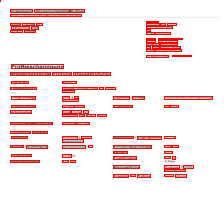

In [6]:
from PIL import ImageDraw


def unnormalize_box(bbox, width, height):
     #x1,y1,x2,y2 = yolobbox2bbox(bbox[0], bbox[1], bbox[2], bbox[3])
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

width, height = image_to_verify.size
draw = ImageDraw.Draw(image_to_verify)
count = 0
for bbox in batch['bbox'][0]:
    #print(bbox)
    
    draw.rectangle(unnormalize_box(bbox, width=width, height=height), outline='red', width=1)
    #draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], outline='red', width=1)
    count+=1
print(count)
    

image_to_verify

[[ 209  241  626  306]
 [ 653  230 1321  306]
 [1342  240 1614  306]
 ...
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


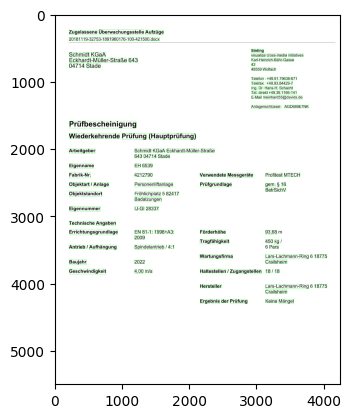

In [14]:
image = cv2.imread('dataset/validation/images/image_0.jpeg')
bbox = batch['bbox'][0].numpy()
print(bbox)
for i in range(len(bbox)):
    cv2.rectangle(image, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), (0, 255, 0), 2)
    #cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
plt.imshow(image)